In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf

In [ ]:
import keras
print("Keras version:", keras.__version__)

Keras version: 2.15.0


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


**1. Load pretrained BILSTM (without Sampling) and ResNet50V2 models**

ResNet model moved from folder LandslideModelsV3_1 to LandslideModels

In [ ]:
resnet_model =  tf.keras.models.load_model('/content/gdrive/My Drive/LandslideModels/CNNMODEL/ResNet_model.h5')

In [ ]:
lstm_ws_model = tf.keras.models.load_model('/content/gdrive/My Drive/LandslideModels/LSTMMODEL/With_TPU/WO_SAMPLING/LSTMModelWSV1.h5')

In [ ]:
bilstm_ws_model = tf.keras.models.load_model('/content/gdrive/My Drive/LandslideModels/BiLSTMMODEL/With_TPU/WO_SAMPLING/BiLSTMModelWSV1.h5')

In [ ]:
print(f"ResNet Summary :,{resnet_model.summary()}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23567936  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24092737 (91.91 MB)
Trainable params: 524801 (2.00 MB)
Non-trainable params: 23567936 (89.90 MB)
_________

In [ ]:
print(f"LSTM summary : ,{lstm_ws_model.summary()}")

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 64)                17664     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17729 (69.25 KB)
Trainable params: 17729 (69.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
LSTM summary : ,None


In [ ]:
print("Bi-Lstm Summary : ",{bilstm_ws_model.summary()})

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirect  (None, 60, 128)           35328     
 ional)                                                          
                                                                 
 dropout_14 (Dropout)        (None, 60, 128)           0         
                                                                 
 bidirectional_19 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 76609 (299.25 KB)
Trainable params: 76609 (299.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Bi-Lstm Summary

**2. Prepare time-series data**

In [ ]:
precip_df = pd.read_csv('/content/gdrive/MyDrive/GLC_Dataset/GLCprecipitationdata.csv')

In [ ]:
precip_df.head()

,Landslide_date,latitude,longitude,precip_30d,precip_60d,landslide_trigger
0,2008-08-01,32.5625,107.4500,214.825043,337.946442,rain
1,2009-01-02,45.4200,-122.6630,86.834053,86.834053,downpour
2,2007-01-19,-11.1295,-75.3587,104.967728,104.967728,downpour
3,2009-07-31,28.8378,81.7080,436.084320,592.209167,monsoon
4,2010-10-16,10.3336,123.8978,231.278992,543.187256,tropical_cyclone


In [ ]:
triggers_rainfall = ['rain','downpour','monsoon','tropical_cyclone','continuous_rain']

In [ ]:
precip_df['landslide_trigger'] = precip_df['landslide_trigger'].apply(lambda x: 1 if x in triggers_rainfall else 0)

In [ ]:
precip_df['landslide_trigger'].unique()

array([1, 0])

In [ ]:
precip_df['is_rainfall_induced'] = ((precip_df['precip_30d']>150.00) & (precip_df['precip_60d']>200.00) & (precip_df['landslide_trigger']==1)).astype(int)

In [ ]:
precip_df.head(20)

,Landslide_date,latitude,longitude,precip_30d,precip_60d,landslide_trigger,is_rainfall_induced
0,2008-08-01,32.56250,107.450000,214.825043,337.946442,1,1
1,2009-01-02,45.42000,-122.663000,86.834053,86.834053,1,0
2,2007-01-19,-11.12950,-75.358700,104.967728,104.967728,1,0
3,2009-07-31,28.83780,81.708000,436.084320,592.209167,1,1
4,2010-10-16,10.33360,123.897800,231.278992,543.187256,1,1
5,2012-02-16,10.70040,124.966800,493.125916,1172.029785,1,1
6,2012-03-30,48.27970,-117.266500,157.029694,215.082565,1,1
7,2007-09-02,24.95310,-107.622000,267.505524,373.613251,1,1
8,2007-09-05,43.68460,-114.419400,14.715376,27.598717,1,0
9,2008-11-01,23.89000,100.084500,185.048218,302.359009,1,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
precip_df['Landslide_date'] = pd.to_datetime(precip_df['Landslide_date'])
precip_df['Landslide_day_of_year'] = precip_df['Landslide_date'].dt.dayofyear
precip_df['Landslide_month'] = precip_df['Landslide_date'].dt.month

In [ ]:
precip_df.head()

,Landslide_date,latitude,longitude,precip_30d,precip_60d,landslide_trigger,is_rainfall_induced,Landslide_day_of_year,Landslide_month
0,2008-08-01,32.5625,107.4500,214.825043,337.946442,1,1,214,8
1,2009-01-02,45.4200,-122.6630,86.834053,86.834053,1,0,2,1
2,2007-01-19,-11.1295,-75.3587,104.967728,104.967728,1,0,19,1
3,2009-07-31,28.8378,81.7080,436.084320,592.209167,1,1,212,7
4,2010-10-16,10.3336,123.8978,231.278992,543.187256,1,1,289,10


In [ ]:
sc = MinMaxScaler()

In [ ]:
precip_df[['precip_30d', 'precip_60d']] = sc.fit_transform(precip_df[['precip_30d', 'precip_60d']])
precip_df[['latitude', 'longitude']] = sc.fit_transform(precip_df[['latitude', 'longitude']])

In [ ]:
sc_dt = MinMaxScaler()
precip_df[['Landslide_day_of_year', 'Landslide_month']] = sc_dt.fit_transform(precip_df[['Landslide_day_of_year', 'Landslide_month']])

In [ ]:
def createseq(data, X_features,y_target, seqlen):
    seq = []
    lab = []
    for i in range(len(data) - seqlen):
        sfeatures = data[X_features].iloc[i:i+seqlen].values
        slabel = data[y_target].iloc[i + seqlen - 1]
        seq.append(sfeatures)
        lab.append(slabel)
    return np.array(seq), np.array(lab)

In [ ]:
BiLstm_features = ['latitude', 'longitude', 'precip_30d', 'precip_60d']
BiLstm_target = 'is_rainfall_induced'
BiLstm_sequence_length = 60

In [ ]:
X_features, y_target = createseq(precip_df, BiLstm_features, BiLstm_target, BiLstm_sequence_length)

In [ ]:
print(f"Shape of X:,{X_features.shape}")
print(f"Shape of Y:,{y_target.shape}")

Shape of X:,(10904, 60, 4)
Shape of Y:,(10904,)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# split the timeseries data as 70% training, 15% as test and 15% as validation
X_train_ts, X_temp_ts, y_train_ts, y_temp_ts = train_test_split(X_features, y_target, test_size=0.3, random_state=42)
X_test_ts, X_val_ts, y_test_ts, y_val_ts = train_test_split(X_temp_ts, y_temp_ts, test_size=0.5, random_state=42)

**3. Preparing Image Data**

In [ ]:
resnetImgdir = '/content/gdrive/My Drive/HR_GLDD_Dataset/HRGLDD_Images/'

In [ ]:
train_images_path = '/content/gdrive/My Drive/HR_GLDD_Dataset/NPY_Files/trainX.npy'
train_labels_path = '/content/gdrive/My Drive/HR_GLDD_Dataset/NPY_Files/trainY.npy'

val_images_path = '/content/gdrive/My Drive/HR_GLDD_Dataset/NPY_Files/valX.npy'
val_labels_path = '/content/gdrive/My Drive/HR_GLDD_Dataset/NPY_Files/valY.npy'

test_images_path = '/content/gdrive/My Drive/HR_GLDD_Dataset/NPY_Files/testX.npy'
test_labels_path = '/content/gdrive/My Drive/HR_GLDD_Dataset/NPY_Files/testY.npy'

In [ ]:
X_train = np.load(train_images_path)
y_train = np.load(train_labels_path)

X_val = np.load(val_images_path)
y_val = np.load(val_labels_path)

X_test = np.load(test_images_path)
y_test = np.load(test_labels_path)

In [ ]:
print(f"X_train: {X_train.shape}, Y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, Y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, Y_test: {y_test.shape}")

X_train: (1119, 128, 128, 4), Y_train: (1119, 128, 128, 1)
X_val: (284, 128, 128, 4), Y_val: (284, 128, 128, 1)
X_test: (355, 128, 128, 4), Y_test: (355, 128, 128, 1)


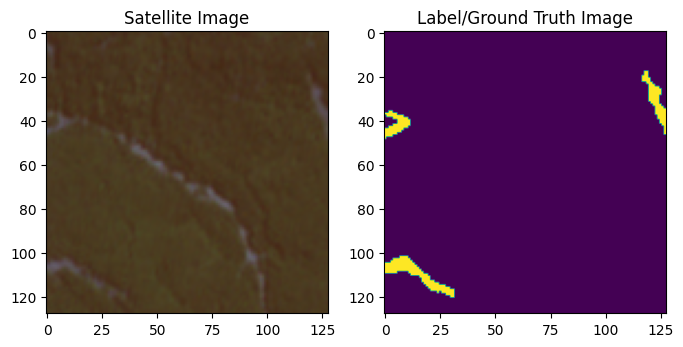

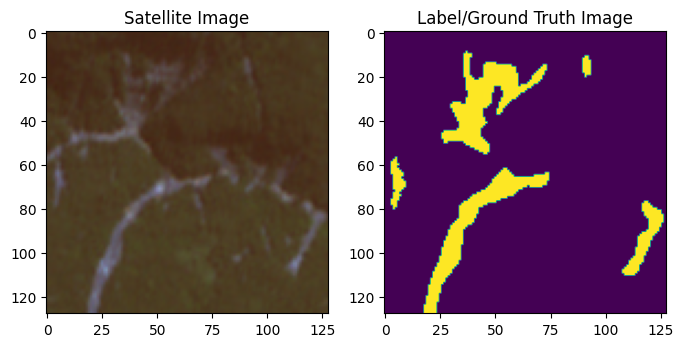

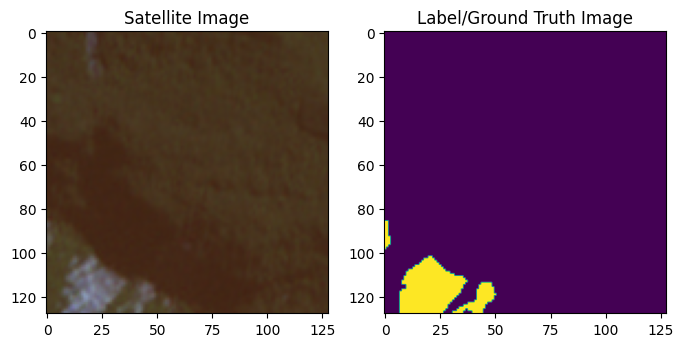

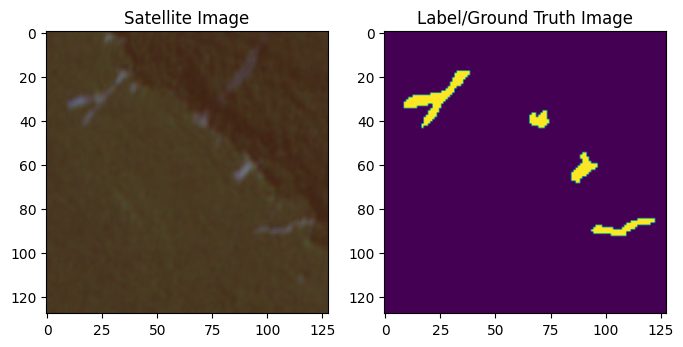

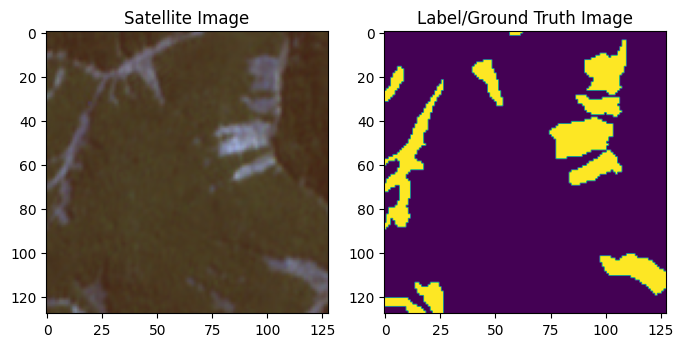

In [ ]:
for i in range(5):
    f, axarr = plt.subplots(1,2,figsize=(8,8))
    #axarr[0].imshow(X_train[i][:,:,:4])
    axarr[0].imshow(X_train[i][:,:,:3])
    axarr[0].set_title("Satellite Image")
    axarr[1].imshow(np.squeeze(y_train[i]))
    axarr[1].set_title("Label/Ground Truth Image")

Reshaping using the mean pixel value of the images in Y-train like if (>0.1) then 1 and (<0.1) then 0. 1 indicates landslides and 0 indicates non-landslides.

In [ ]:
Y_train = (np.mean(y_train, axis=(1, 2, 3)) > 0.1).astype(int).reshape(-1, 1)
Y_val = (np.mean(y_val, axis=(1, 2, 3)) > 0.1).astype(int).reshape(-1, 1)
Y_test = (np.mean(y_test, axis=(1, 2, 3)) > 0.1).astype(int).reshape(-1, 1)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

In [ ]:
for layer in bilstm_ws_model.layers:
    print(layer.name)

bidirectional_18
dropout_14
bidirectional_19
dense_14


In [ ]:
for layer in resnet_model.layers:
    print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_2
dropout_1
dense_3


Second to the last layer are choosen in the below cell, as in neural network,as the early layer will learn low level features in data like edges and texture when we consider CNN models while the later layers deep layers will learn complex features in data , same goes for LSTM ,later layers will learn long-term dependencies.

In [ ]:
bilstm_ws_features = Model(inputs=bilstm_ws_model.input, outputs=bilstm_ws_model.layers[-2].output)

In [ ]:
print(f"output Shape of BiLSTM model : {bilstm_ws_features.output_shape}")

output Shape of BiLSTM model : (None, 64)


In [ ]:
resNet_features =  Model(inputs=resnet_model.input, outputs=resnet_model.layers[-2].output)

In [ ]:
print(f"output Shape of ResNet model : {resNet_features.output_shape}")

output Shape of ResNet model : (None, 256)


4. Building Combined Model using Feature Fusion extraction.

feature extraction using the modified models to extract the features

**Bi-LSTM model features extraction**

In [ ]:
BiLSTM_X_train = bilstm_ws_features.predict(X_train_ts)

239/239 [==============================] - 6s 18ms/step


In [ ]:
print(f"Shape of features training data (Bi-LSTM) : {BiLSTM_X_train.shape}")

Shape of features training data (Bi-LSTM) : (7632, 64)


In [ ]:
BiLSTM_X_test = bilstm_ws_features.predict(X_test_ts)

52/52 [==============================] - 1s 17ms/step


In [ ]:
print(f"Shape of features testing data (BiLSTM) : {BiLSTM_X_test.shape}")

Shape of features testing data (BiLSTM) : (1636, 64)


In [ ]:
BiLSTM_X_val = bilstm_ws_features.predict(X_val_ts)

52/52 [==============================] - 1s 19ms/step


In [ ]:
print(f"Shape of features validation data (BiLSTM) : {BiLSTM_X_val.shape}")

Shape of features validation data (BiLSTM) : (1636, 64)


**ResNet model features extraction**

In [ ]:
ResNet_X_train = resNet_features.predict(X_train)

35/35 [==============================] - 72s 2s/step


In [ ]:
print(f"Shape of features train data (ReSNet) : {ResNet_X_train.shape}")

Shape of features train data (ReSNet) : (1119, 256)


In [ ]:
ResNet_X_test = resNet_features.predict(X_test)

12/12 [==============================] - 22s 2s/step


In [ ]:
print(f"Shape of features test data (ReSNet) : {ResNet_X_test.shape}")

Shape of features test data (ReSNet) : (355, 256)


In [ ]:
ResNet_X_val = resNet_features.predict(X_val)

9/9 [==============================] - 17s 2s/step


In [ ]:
print(f"Shape of features validation data (ReSNet) : {ResNet_X_val.shape}")

Shape of features validation data (ReSNet) : (284, 256)


to make sure that both input(features) set have same number of samples.

In [ ]:
optimizing_features = min(len(BiLSTM_X_train),len(ResNet_X_train))

In [ ]:
optimizing_features

1119

In [ ]:
BiLSTM_X_train_OP = BiLSTM_X_train[:optimizing_features]

In [ ]:
len(BiLSTM_X_train_OP)

1119

In [ ]:
ResNet_X_train_OP = ResNet_X_train[:optimizing_features]

In [ ]:
combined_X_train_F = np.concatenate([BiLSTM_X_train_OP,ResNet_X_train_OP],axis=1)

In [ ]:
print(f"Shape of combined features: {combined_X_train_F.shape}")

Shape of combined features: (1119, 320)


In [ ]:
combined_X_train_F[1]

array([ 4.72867012e-01,  5.05693614e-01,  5.58504224e-01, -6.75838470e-01,
       -1.07355267e-01,  3.17802846e-01,  3.32056612e-01, -4.21728760e-01,
       -2.43279070e-01, -4.92595375e-01,  6.23586655e-01, -2.39084303e-01,
       -6.07968807e-01,  7.01673031e-01,  6.77492917e-01,  3.23635489e-02,
       -4.91562545e-01,  7.31649041e-01,  4.20607358e-01,  6.60879791e-01,
       -5.55037379e-01,  2.98007727e-01, -8.60813111e-02, -4.52073365e-01,
        3.31268340e-01, -2.14314118e-01, -8.12797070e-01,  3.90656173e-01,
        7.30915427e-01, -8.76477599e-01, -7.20769048e-01,  8.77409801e-02,
       -4.02537221e-03,  8.12861741e-01,  7.55678955e-03, -4.97446805e-02,
       -1.46322651e-02, -2.34721869e-04, -1.39172236e-03, -2.30229716e-03,
        2.93622110e-02,  6.40664250e-02, -3.76887154e-03,  5.02621813e-04,
        7.01726079e-01,  7.68833756e-01, -1.38108758e-02, -6.25377059e-01,
       -8.13705288e-03,  6.11131340e-02,  1.77511666e-02, -1.24032414e-02,
        9.28422451e-01, -

In [ ]:
y_train_ts.shape

(7632,)

In [ ]:
combined_Y_train_T =  y_train_ts[:optimizing_features]

In [ ]:
print(f"Shape of combined target : {combined_Y_train_T.shape}")

Shape of combined target : (1119,)


In [ ]:
optimizing_val_f = min(len(BiLSTM_X_val),len(ResNet_X_val))

In [ ]:
BiLSTM_X_val_OP = BiLSTM_X_val[:optimizing_val_f]

In [ ]:
ResNet_X_val_OP = ResNet_X_val[:optimizing_val_f]

In [ ]:
combined_X_val_F = np.concatenate([BiLSTM_X_val_OP,ResNet_X_val_OP],axis=1)

In [ ]:
y_val_ts.shape

(1636,)

In [ ]:
combined_Y_val_T =  y_val_ts[:optimizing_val_f]

In [ ]:
print(f"Shape of combined validation target : {combined_Y_val_T.shape}")

Shape of combined validation target : (284,)


In [ ]:
optimizing_test_f = min(len(BiLSTM_X_test),len(ResNet_X_test))

In [ ]:
BiLSTM_X_test_OP = BiLSTM_X_test[:optimizing_test_f]

In [ ]:
ResNet_X_test_OP = ResNet_X_test[:optimizing_test_f]

In [ ]:
combined_X_test_F = np.concatenate([BiLSTM_X_test_OP,ResNet_X_test_OP],axis=1)

In [ ]:
y_test_ts.shape

(1636,)

In [ ]:
combined_Y_test_T = y_test_ts[:optimizing_test_f]

In [ ]:
print(f"Shape of combined validation target : {combined_Y_test_T.shape}")

Shape of combined validation target : (355,)


In [ ]:
combined_input_layer = Input(shape=(combined_X_train_F.shape[1]))

In [ ]:
FLayer = Dense(256,activation='relu')(combined_input_layer) # first layer -128 neuron - RELU activation (to learn complex patterns in data) - with features as input

In [ ]:
addlayer = Dropout(0.3)(FLayer)

In [ ]:
SLayer = Dense(128,activation='relu')(addlayer) # first layer -64 neuron - RELU activation (to learn complex patterns in data) - with first layer features as input

In [ ]:
lstLayer = Dense(1,activation='sigmoid')(SLayer) #last Layer will act as a Binary Classification

In [ ]:
combinedModel = Model(inputs=combined_input_layer,outputs=lstLayer)

In [ ]:
combinedModel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense (Dense)               (None, 128)               41088     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49409 (193.00 KB)
Trainable params: 49409 (193.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Nuerons increased in first layer and adjusted across in preceding layers after observing the performance

In [ ]:
combinedModel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)
checkpoint_cb = ModelCheckpoint(filepath='/content/gdrive/My Drive/LandslideModels/CombinedMODEL/CB_model.h5',monitor='val_loss',save_best_only=True,verbose=1)

In [ ]:
history = None

In [ ]:
combinedModel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense (Dense)               (None, 256)               82176     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 115201 (450.00 KB)
Trainable params: 115201 (450.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history=combinedModel.fit(combined_X_train_F, combined_Y_train_T,validation_data=(combined_X_val_F, combined_Y_val_T),epochs=50,batch_size=32,callbacks=[earlystopping, lr,checkpoint_cb])

Epoch 1/50
19/35 [===============>..............] - ETA: 0s - loss: 0.2053 - accuracy: 0.9211
Epoch 1: val_loss did not improve from 0.24690
35/35 [==============================] - 0s 5ms/step - loss: 0.2210 - accuracy: 0.9017 - val_loss: 0.2472 - val_accuracy: 0.8908 - lr: 1.2500e-04
Epoch 2/50
20/35 [================>.............] - ETA: 0s - loss: 0.2107 - accuracy: 0.9000
Epoch 2: val_loss did not improve from 0.24690
35/35 [==============================] - 0s 4ms/step - loss: 0.2186 - accuracy: 0.8990 - val_loss: 0.2482 - val_accuracy: 0.8979 - lr: 1.2500e-04
Epoch 3/50
20/35 [================>.............] - ETA: 0s - loss: 0.2156 - accuracy: 0.9062
Epoch 3: val_loss did not improve from 0.24690
35/35 [==============================] - 0s 4ms/step - loss: 0.2180 - accuracy: 0.9035 - val_loss: 0.2476 - val_accuracy: 0.8979 - lr: 1.2500e-04
Epoch 4/50
20/35 [================>.............] - ETA: 0s - loss: 0.2300 - accuracy: 0.9016
Epoch 4: val_loss did not improve from 0.2469

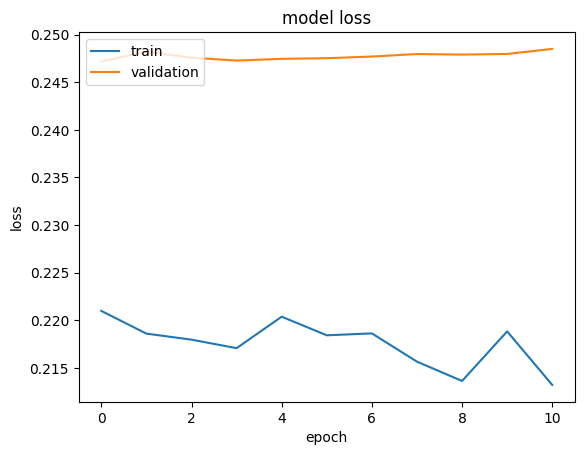

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

with Regularization

In [ ]:
from keras.regularizers import l1_l2

In [ ]:
combined_input_layer = Input(shape=(combined_X_train_F.shape[1]))
FLayer_2 = Dense(256,activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(combined_input_layer)
addlayer_2 = Dropout(0.3)(FLayer_2)
SLayer_2 = Dense(128,activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(addlayer_2)
lstLayer_2 = Dense(1,activation='sigmoid')(SLayer_2)
combinedModel_2 = Model(inputs=combined_input_layer,outputs=lstLayer_2)

In [ ]:
combinedModel_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 320)]             0         
                                                                 
 dense_6 (Dense)             (None, 256)               82176     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 115201 (450.00 KB)
Trainable params: 115201 (450.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
combinedModel_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)
checkpoint_cb = ModelCheckpoint(filepath='/content/gdrive/My Drive/LandslideModels/CombinedMODEL/CB_model_2.h5',monitor='val_loss',save_best_only=True,verbose=1)

In [ ]:
history=combinedModel_2.fit(combined_X_train_F, combined_Y_train_T,validation_data=(combined_X_val_F, combined_Y_val_T),epochs=50,batch_size=32,callbacks=[earlystopping, lr,checkpoint_cb])

Epoch 1/50
31/35 [=========================>....] - ETA: 0s - loss: 50.4567 - accuracy: 0.8296
Epoch 1: val_loss improved from inf to 31.28585, saving model to /content/gdrive/My Drive/LandslideModels/CombinedMODEL/CB_model_2.h5
35/35 [==============================] - 1s 15ms/step - loss: 48.5183 - accuracy: 0.8302 - val_loss: 31.2859 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 2/50
 1/35 [..............................] - ETA: 0s - loss: 31.2361 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/35 [========================>.....] - ETA: 0s - loss: 21.2037 - accuracy: 0.8865
Epoch 2: val_loss improved from 31.28585 to 10.00748, saving model to /content/gdrive/My Drive/LandslideModels/CombinedMODEL/CB_model_2.h5
35/35 [==============================] - 0s 7ms/step - loss: 19.8023 - accuracy: 0.8865 - val_loss: 10.0075 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 3/50
33/35 [===========================>..] - ETA: 0s - loss: 5.2557 - accuracy: 0.8797
Epoch 3: val_loss improved from 10.00748 to 1.87582, saving model to /content/gdrive/My Drive/LandslideModels/CombinedMODEL/CB_model_2.h5
35/35 [==============================] - 0s 6ms/step - loss: 5.0731 - accuracy: 0.8794 - val_loss: 1.8758 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 4/50
33/35 [===========================>..] - ETA: 0s - loss: 1.1597 - accuracy: 0.8750
Epoch 4: val_loss improved from 1.87582 to 0.73227, saving model to /content/gdrive/My Drive/LandslideModels/CombinedMODEL/CB_model_2.h5
35/35 [=====================

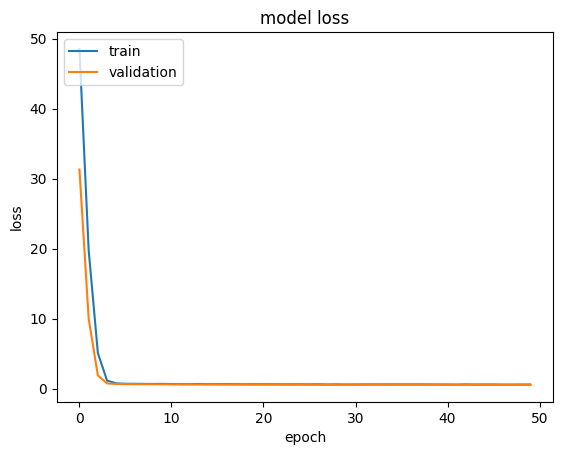

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

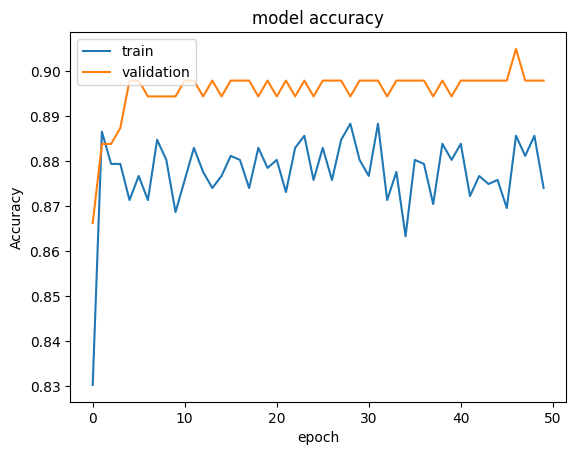

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss_testdata, acc_testdata = combinedModel_2.evaluate(combined_X_test_F, combined_Y_test_T)
print(f"Test Loss: {loss_testdata}")
print(f"Test Accuracy: {acc_testdata}")

12/12 [==============================] - 0s 2ms/step - loss: 0.5187 - accuracy: 0.8761
Test Loss: 0.5187294483184814
Test Accuracy: 0.8760563135147095
